### Import Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error as mse
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from statsmodels.tsa.seasonal import seasonal_decompose
from keras.models import Sequential
from keras.layers import Dense,Activation,Dropout
from sklearn import preprocessing
from keras.wrappers.scikit_learn import KerasRegressor                   
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import r2_score
from pmdarima import auto_arima

### Import Dataset

In [38]:
df = pd.read_csv("monkeypox.csv")
df.head()

C:\Users\Rakesh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\IPython\core\interactiveshell.py:3441: DtypeWarning: Columns (14,18,21,24,34) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,ID,Status,Location,City,Country,Country_ISO3,Age,Gender,Date_onset,Date_confirmation,...,Source,Source_II,Source_III,Source_IV,Source_V,Source_VI,Source_VII,Date_entry,Date_death,Date_last_modified
0,N1,confirmed,Guy's and St Thomas Hospital London,London,England,GBR,NaN,NaN,2022-04-29,2022-05-06,...,https://www.gov.uk/government/news/monkeypox-c...,https://www.who.int/emergencies/disease-outbre...,NaN,NaN,NaN,NaN,NaN,2022-05-18,NaN,2022-05-18
1,N2,confirmed,Guy's and St Thomas Hospital London,London,England,GBR,NaN,NaN,2022-05-05,2022-05-12,...,https://www.gov.uk/government/news/monkeypox-c...,NaN,NaN,NaN,NaN,NaN,NaN,2022-05-18,NaN,2022-05-18
2,N3,confirmed,London,London,England,GBR,NaN,NaN,2022-04-30,2022-05-13,...,https://www.gov.uk/government/news/monkeypox-c...,NaN,NaN,NaN,NaN,NaN,NaN,2022-05-18,NaN,2022-05-18
3,N4,confirmed,London,London,England,GBR,NaN,Male,NaN,2022-05-15,...,https://www.gov.uk/government/news/monkeypox-c...,NaN,NaN,NaN,NaN,NaN,NaN,2022-05-18,NaN,2022-05-18
4,N5,confirmed,London,London,England,GBR,NaN,Male,NaN,2022-05-15,...,https://www.gov.uk/government/news/monkeypox-c...,NaN,NaN,NaN,NaN,NaN,NaN,2022-05-18,NaN,2022-05-18


In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27019 entries, 0 to 27018
Data columns (total 36 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       27018 non-null  object 
 1   Status                   27018 non-null  object 
 2   Location                 18210 non-null  object 
 3   City                     1040 non-null   object 
 4   Country                  27018 non-null  object 
 5   Country_ISO3             27018 non-null  object 
 6   Age                      2381 non-null   object 
 7   Gender                   1810 non-null   object 
 8   Date_onset               46 non-null     object 
 9   Date_confirmation        24981 non-null  object 
 10  Symptoms                 188 non-null    object 
 11  Hospitalised (Y/N/NA)    242 non-null    object 
 12  Date_hospitalisation     30 non-null     object 
 13  Isolated (Y/N/NA)        389 non-null    object 
 14  Date_isolation        

### Preprocessing

In [40]:
# Drop rows with empty dates 
df.dropna(subset=['Date_entry'], inplace=True)
df['Date_entry'].isnull().sum()

0

In [41]:
# Set date as index
df.Date_entry = pd.to_datetime(df.Date_entry)
df.set_index('Date_entry')

,ID,Status,Location,City,Country,Country_ISO3,Age,Gender,Date_onset,Date_confirmation,...,Confirmation_method,Source,Source_II,Source_III,Source_IV,Source_V,Source_VI,Source_VII,Date_death,Date_last_modified
Date_entry,,,,,,,,,,,,,,,,,,,,,
2022-05-18,N1,confirmed,Guy's and St Thomas Hospital London,London,England,GBR,NaN,NaN,2022-04-29,2022-05-06,...,RT-PCR,https://www.gov.uk/government/news/monkeypox-c...,https://www.who.int/emergencies/disease-outbre...,NaN,NaN,NaN,NaN,NaN,NaN,2022-05-18
2022-05-18,N2,confirmed,Guy's and St Thomas Hospital London,London,England,GBR,NaN,NaN,2022-05-05,2022-05-12,...,RT-PCR,https://www.gov.uk/government/news/monkeypox-c...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-05-18
2022-05-18,N3,confirmed,London,London,England,GBR,NaN,NaN,2022-04-30,2022-05-13,...,RT-PCR,https://www.gov.uk/government/news/monkeypox-c...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-05-18
2022-05-18,N4,confirmed,London,London,England,GBR,NaN,Male,NaN,2022-05-15,...,NaN,https://www.gov.uk/government/news/monkeypox-c...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-05-18
2022-05-18,N5,confirmed,London,London,England,GBR,NaN,Male,NaN,2022-05-15,...,NaN,https://www.gov.uk/government/news/monkeypox-c...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-05-18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-28,E1890,suspected,Imo,NaN,Nigeria,NGA,NaN,NaN,NaN,NaN,...,NaN,https://ncdc.gov.ng/themes/common/files/sitrep...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-07-28
2022-07-28,E1891,suspected,Delta,NaN,Nigeria,NGA,NaN,NaN,NaN,NaN,...,NaN,https://ncdc.gov.ng/themes/common/files/sitrep...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-07-28
2022-07-28,E1892,suspected,Anambra,NaN,Nigeria,NGA,NaN,NaN,NaN,NaN,...,NaN,https://ncdc.gov.ng/themes/common/files/sitrep...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-07-28


In [42]:
# Aggregate the cases based on date
df_cnt1 = df[df['Status'] == "confirmed"]
df_cnt = df.groupby(['Date_entry']).count()
df_cnt = df_cnt[['ID', 'Status']]
df_cnt.head()

,ID,Status
Date_entry,,
2022-05-18,63,63
2022-05-19,40,40
2022-05-20,37,37
2022-05-21,44,44
2022-05-22,7,7


In [43]:
df_cnt.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 65 entries, 2022-05-18 to 2022-08-02
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   ID      65 non-null     int64
 1   Status  65 non-null     int64
dtypes: int64(2)
memory usage: 1.5 KB


In [44]:
# Filter Confirmed Cases
df_cnt1.set_index('Date_entry')
df_cnt1 = df_cnt1.groupby(['Date_entry']).count()
df_cnt1 = df_cnt1[['ID']]
df_cnt1.head()

,ID
Date_entry,
2022-05-18,63
2022-05-19,40
2022-05-20,34
2022-05-21,40
2022-05-22,6


[Text(0.5, 0, 'Dates'), Text(0, 0.5, 'Cases')]

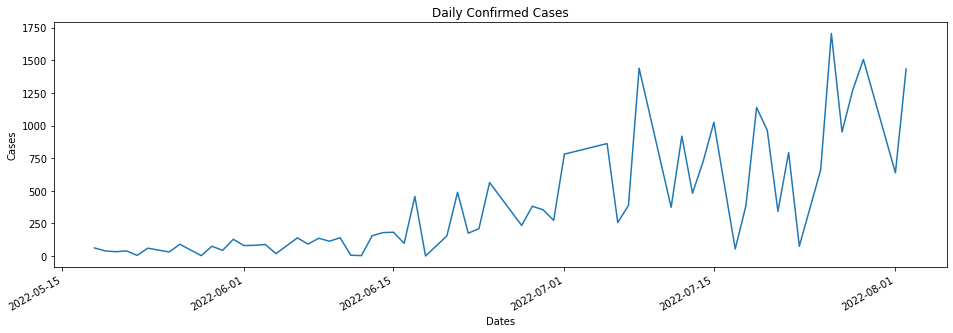

In [45]:
ax = df_cnt1['ID'].plot(figsize = (16,5), title = "Daily Confirmed Cases")
ax.set(xlabel='Dates', ylabel='Cases')

In [46]:
df_cnt1.index = pd.DatetimeIndex(df_cnt1.index).to_period('D')
df_cnt1 = df_cnt1.resample('D').pad()
train_data = df_cnt1[:len(df_cnt1)-12]
test_data = df_cnt1[len(df_cnt1)-12:]

### ARIMA

In [48]:
AARIMA = auto_arima(df_cnt1['ID'], seasonal=True, m=12,max_p=7, max_d=5,max_q=7, max_P=4, max_D=4,max_Q=4)
print(AARIMA.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   77
Model:               SARIMAX(0, 1, 1)   Log Likelihood                -548.112
Date:                Mon, 10 Oct 2022   AIC                           1102.224
Time:                        21:10:15   BIC                           1109.217
Sample:                             0   HQIC                          1105.019
                                 - 77                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     16.2609      7.847      2.072      0.038       0.882      31.640
ma.L1         -0.7916      0.052    -15.326      0.000      -0.893      -0.690
sigma2      1.064e+05   1.39e+04      7.679      0.0

In [50]:
# Fit the model
arima_model = ARIMA(train_data['ID'], order = (3,2,3))
arima_result = arima_model.fit()
print(arima_result.summary())

C:\Users\Rakesh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                     ID   No. Observations:                   65
Model:                 ARIMA(3, 2, 3)   Log Likelihood                -442.678
Date:                Mon, 10 Oct 2022   AIC                            899.356
Time:                        21:10:19   BIC                            914.358
Sample:                    05-18-2022   HQIC                           905.256
                         - 07-21-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8656      0.205     -4.219      0.000      -1.268      -0.464
ar.L2         -1.1345      0.122     -9.309      0.000      -1.373      -0.896
ar.L3         -0.4888      0.212     -2.306      0.0

C:\Users\Rakesh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


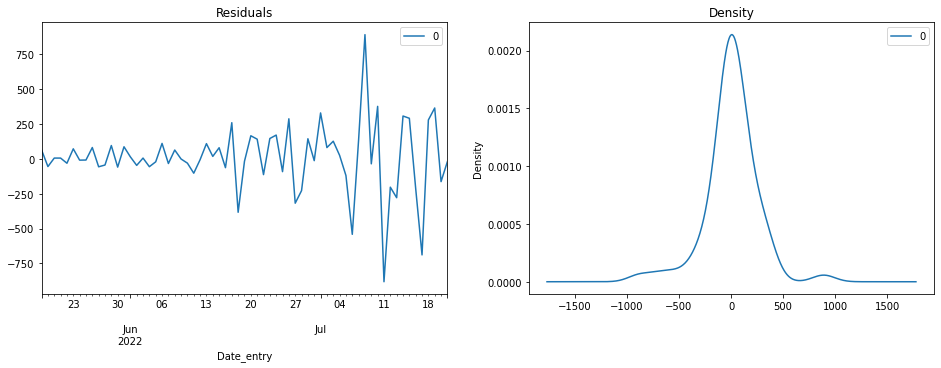

In [52]:
# Plot residual errors
residuals = pd.DataFrame(arima_result.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0], figsize = (16,5))
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

Text(0.5, 1.0, 'Forecast vs Training')

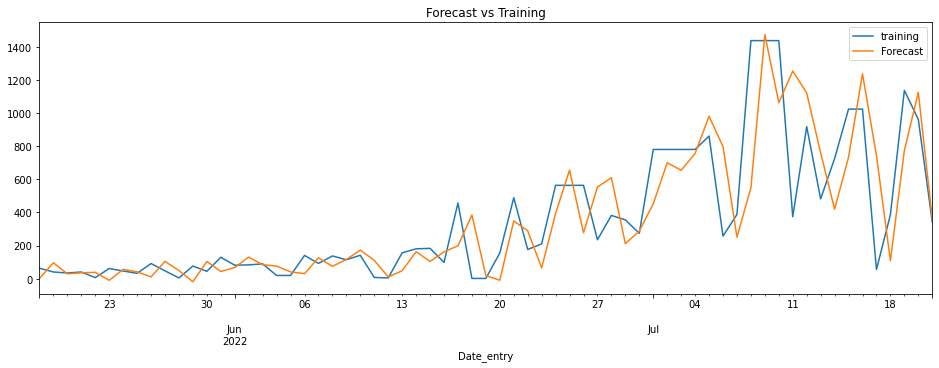

In [53]:
# Test Model Fit
arima_res = arima_result.get_prediction(start = train_data.index[0], end = train_data.index[-1], typ="levels")
arima_pred = arima_res.predicted_mean
train_data['ID'].plot(figsize = (16,5), legend=True, label='training')
arima_pred.plot(figsize = (16,5), legend=True, label='Forecast')
plt.title('Forecast vs Training')

In [54]:
# Predict the test data
arima_res = arima_result.get_prediction(start = test_data.index[0], end = test_data.index[-1], typ="levels")
arima_pred = arima_res.predicted_mean
arima_conf = arima_res.conf_int(alpha=0.05)
lower_series = pd.Series(arima_conf['lower ID'], index=test_data.index)
upper_series = pd.Series(arima_conf['upper ID'], index=test_data.index)

<AxesSubplot:xlabel='Date_entry'>

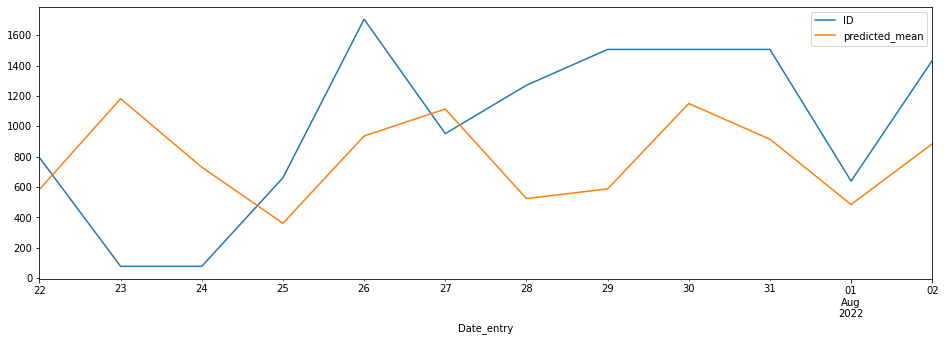

In [56]:
# plot predictions
test_data['ID'].plot(figsize = (16,5), legend=True)
arima_pred.plot(legend = True)

Text(0.5, 1.0, 'Forecast vs Actuals')

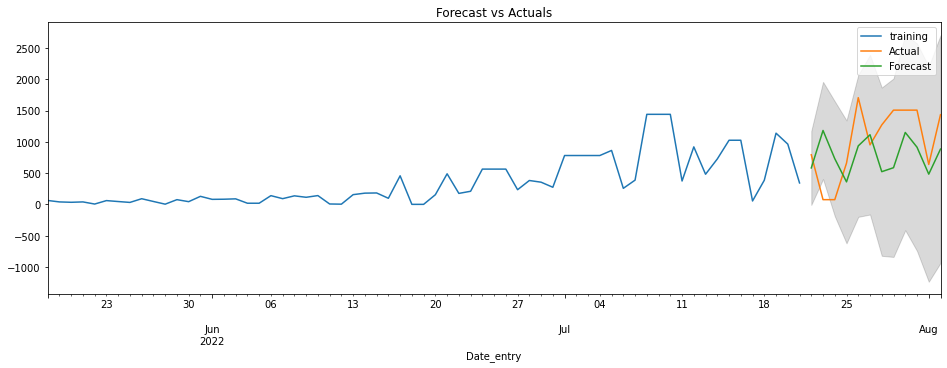

In [57]:
# Compared predictions
train_data['ID'].plot(figsize = (16,5), legend=True, label='training')
test_data['ID'].plot(figsize = (16,5), legend=True, label='Actual')
arima_pred.plot(figsize = (16,5), legend=True, label='Forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
plt.title('Forecast vs Actuals')

In [59]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(forecast-actual)[1]              # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 'mpe': mpe, 'rmse':rmse, 'acf1':acf1,'corr':corr, 'minmax':minmax})

forecast_accuracy(arima_pred.values, test_data['ID'])

<ipython-input-59-1670b04e1821>:9: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mins = np.amin(np.hstack([forecast[:,None], actual[:,None]]), axis=1)
<ipython-input-59-1670b04e1821>:10: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  maxs = np.amax(np.hstack([forecast[:,None], actual[:,None]]), axis=1)


{'mape': 2.2449808985208737,
 'me': -223.1471967303221,
 'mae': 543.3143796119142,
 'mpe': 1.640788542794743,
 'rmse': 619.717874200988,
 'acf1': 0.3000029637448481,
 'corr': 0.10929567463406334,
 'minmax': 0.46685483278797524}

### PROPHET

In [61]:
df_fb  = pd.DataFrame({"ds":[],"y":[]})
df_fb_test  = pd.DataFrame({"ds":[],"y":[]})
df_fb["ds"] = pd.to_datetime(train_data.index.to_timestamp())
df_fb["y"]  = train_data.iloc[:,0].values
df_fb_test["ds"] = pd.to_datetime(test_data.index.to_timestamp())
df_fb_test["y"]  = test_data.iloc[:,0].values

m = Prophet()
m.fit(df_fb)
future = m.make_future_dataframe(periods=len(df_fb_test.index),freq='D')
prophet_pred = m.predict(future)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


In [62]:
prophet_pred = pd.DataFrame({"Date" : prophet_pred[-len(df_fb_test.index):]['ds'], "Pred" : prophet_pred[-len(df_fb_test.index):]["yhat"]})
prophet_pred = prophet_pred.set_index("Date")
prophet_pred.index.freq = "D"
prophet_pred

,Pred
Date,
2022-07-22,1044.352441
2022-07-23,966.816768
2022-07-24,862.814672
2022-07-25,794.622087
2022-07-26,1006.455113
2022-07-27,862.091024
2022-07-28,825.842330
2022-07-29,1151.562905
2022-07-30,1074.027232


<AxesSubplot:xlabel='Date'>

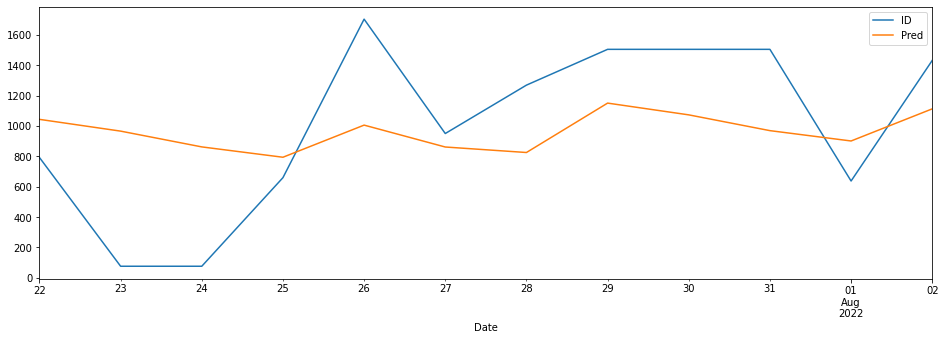

In [64]:
# plot predictions
test_data['ID'].plot(figsize = (16,5), legend=True)
prophet_pred['Pred'].plot(legend = True)

Text(0.5, 1.0, 'Forecast vs Actuals')

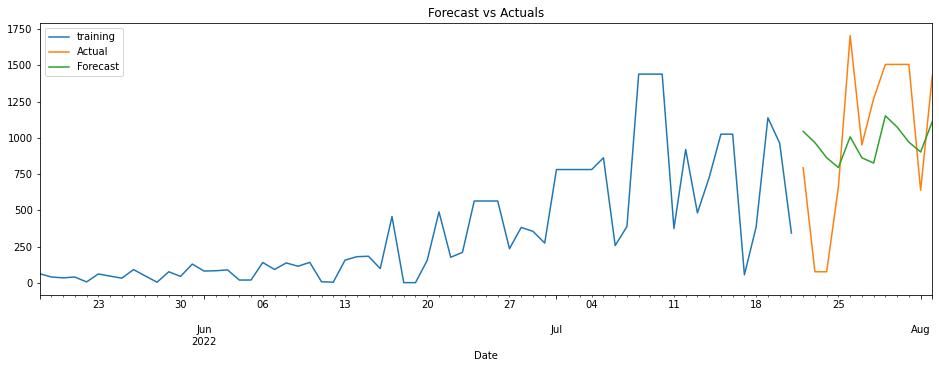

In [66]:
# Compared predictions
train_data['ID'].plot(figsize = (16,5), legend=True, label='training')
test_data['ID'].plot(figsize = (16,5), legend=True, label='Actual')
prophet_pred['Pred'].plot(figsize = (16,5), legend=True, label='Forecast')
plt.title('Forecast vs Actuals')

In [67]:
forecast_accuracy(prophet_pred['Pred'].values, test_data['ID'])

<ipython-input-59-1670b04e1821>:9: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mins = np.amin(np.hstack([forecast[:,None], actual[:,None]]), axis=1)
<ipython-input-59-1670b04e1821>:10: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  maxs = np.amax(np.hstack([forecast[:,None], actual[:,None]]), axis=1)


{'mape': 2.0802008630107394,
 'me': -45.491013635974696,
 'mae': 433.3974335782336,
 'mpe': 1.754560034638166,
 'rmse': 496.5007611405743,
 'acf1': 0.4537132436910168,
 'corr': 0.5089766847687165,
 'minmax': 0.37414988019051054}

### Proposed Model

In [68]:
# Arima Rolling Forecast
predicted1, resid_test = [], []
history = train_data.values
history = list(history)
test = test_data.values
for t in range(len(test)):
    model = ARIMA(history, order=(9,0,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    resid_test.append(test[t] - output[0])
    predicted1.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))

predicted=566.628109, expected=793.000000
predicted=881.823156, expected=76.000000
predicted=40.547497, expected=76.000000
predicted=507.602309, expected=660.000000
predicted=1092.599724, expected=1705.000000
predicted=656.146926, expected=951.000000
predicted=391.168261, expected=1270.000000
predicted=910.113319, expected=1506.000000
predicted=1045.261432, expected=1506.000000
predicted=1009.697659, expected=1506.000000
predicted=1954.904021, expected=638.000000
predicted=869.381786, expected=1433.000000


Test MSE: 402081.121


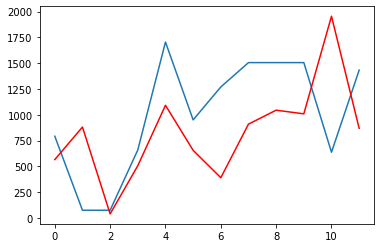

In [69]:
test_resid = []
for i in resid_test:
    test_resid.append(i[0])
error = mean_squared_error(test, predicted1)
print('Test MSE: %.3f' % error)
plt.plot(test)
plt.plot(predicted1, color='red')
plt.show()

In [70]:
window_size = 6
def make_model(window_size):
    model = Sequential()
    model.add(Dense(50, input_dim=window_size, activation="tanh"))
    model.add(Dense(25, activation="tanh"))
    model.add(Dense(1))
    model.add(Activation("linear"))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [72]:
model = make_model(6)
min_max_scaler = preprocessing.MinMaxScaler()
train = train_data.values
train = np.array(train).reshape(-1,1)
train_scaled = min_max_scaler.fit_transform(test)

In [73]:
train_X,train_Y = [],[]
for i in range(0 , len(train_scaled) - window_size):
    train_X.append(train_scaled[i:i+window_size])
    train_Y.append(train_scaled[i+window_size])
new_train_X,new_train_Y = [],[]
for i in train_X:
    new_train_X.append(i.reshape(-1))
for i in train_Y:
    new_train_Y.append(i.reshape(-1))
new_train_X = np.array(new_train_X)
new_train_Y = np.array(new_train_Y)
model.fit(new_train_X,new_train_Y, epochs=100, batch_size=512, validation_split = .05)

Epoch 1/100
1/1 [==============================] - 1s 1s/step - loss: 0.4962 - val_loss: 0.5036
Epoch 2/100
1/1 [==============================] - 0s 31ms/step - loss: 0.3623 - val_loss: 0.3449
Epoch 3/100
1/1 [==============================] - 0s 35ms/step - loss: 0.2560 - val_loss: 0.2190
Epoch 4/100
1/1 [==============================] - 0s 22ms/step - loss: 0.1771 - val_loss: 0.1253
Epoch 5/100
1/1 [==============================] - 0s 22ms/step - loss: 0.1243 - val_loss: 0.0614
Epoch 6/100
1/1 [==============================] - 0s 23ms/step - loss: 0.0948 - val_loss: 0.0234
Epoch 7/100
1/1 [==============================] - 0s 22ms/step - loss: 0.0844 - val_loss: 0.0052
Epoch 8/100
1/1 [==============================] - 0s 22ms/step - loss: 0.0873 - val_loss: 7.1524e-05
Epoch 9/100
1/1 [==============================] - 0s 22ms/step - loss: 0.0971 - val_loss: 0.0014
Epoch 10/100
1/1 [==============================] - 0s 24ms/step - loss: 0.1082 - val_loss: 0.0044
Epoch 11/100
1/1 

1/1 [==============================] - 0s 26ms/step - loss: 7.2755e-04 - val_loss: 0.0999
Epoch 84/100
1/1 [==============================] - 0s 38ms/step - loss: 6.6306e-04 - val_loss: 0.1003
Epoch 85/100
1/1 [==============================] - 0s 52ms/step - loss: 5.9650e-04 - val_loss: 0.1012
Epoch 86/100
1/1 [==============================] - 0s 47ms/step - loss: 5.2840e-04 - val_loss: 0.1024
Epoch 87/100
1/1 [==============================] - 0s 45ms/step - loss: 4.6195e-04 - val_loss: 0.1039
Epoch 88/100
1/1 [==============================] - 0s 40ms/step - loss: 4.0128e-04 - val_loss: 0.1055
Epoch 89/100
1/1 [==============================] - 0s 40ms/step - loss: 3.4952e-04 - val_loss: 0.1070
Epoch 90/100
1/1 [==============================] - 0s 38ms/step - loss: 3.0770e-04 - val_loss: 0.1084
Epoch 91/100
1/1 [==============================] - 0s 25ms/step - loss: 2.7448e-04 - val_loss: 0.1096
Epoch 92/100
1/1 [==============================] - 0s 37ms/step - loss: 2.4698e-04 - 

In [76]:
test_extended = train.tolist()[-1*window_size:] + test_resid
test_data = []
for i in test_extended:
    try:
        test_data.append(i[0])
    except:
        test_data.append(i)
test_data = np.array(test_data).reshape(-1,1)
min_max_scaler = preprocessing.MinMaxScaler()
test_scaled = min_max_scaler.fit_transform(test_data)


In [77]:
test_X,test_Y = [],[]
for i in range(0 , len(test_scaled) - window_size):
    test_X.append(test_scaled[i:i+window_size])
    test_Y.append(test_scaled[i+window_size])
    new_test_X,new_test_Y = [],[]
for i in test_X:
    new_test_X.append(i.reshape(-1))
for i in test_Y:
    new_test_Y.append(i.reshape(-1))
new_test_X = np.array(new_test_X)
new_test_Y = np.array(new_test_Y)

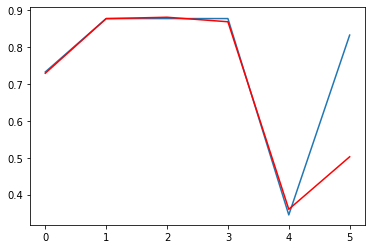

Test MSE: 849521.682


In [78]:
predictions = model.predict(new_train_X)
predictions_rescaled=min_max_scaler.inverse_transform(predictions)
Y = pd.DataFrame(new_train_Y)
pred = pd.DataFrame(predictions)
plt.plot(Y)
plt.plot(pred , color = 'r')
plt.show()
test_resid = test_resid[0:6]
error = mse(test_resid,predictions_rescaled)
print('Test MSE: %.3f' % error)

In [79]:
forecast_accuracy(predictions, new_train_Y)

C:\Users\Rakesh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\lib\function_base.py:2821: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\Rakesh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\lib\function_base.py:2680: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
C:\Users\Rakesh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\lib\function_base.py:2680: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


{'mape': 0.0766029413402521,
 'me': -0.05394142323082295,
 'mae': 0.06023599536098875,
 'mpe': -0.06047130901601097,
 'rmse': 0.13503961809315904,
 'acf1': -0.08237121797376479,
 'corr': nan,
 'minmax': 0.07628708473319346}